In [27]:
import pandas as pd
import numpy as np
import re
import warnings
from datetime import datetime
from math import ceil

from pandas.tools.plotting import scatter_matrix

# from glm.glm import GLM
# from glm.families import Gaussian, Bernoulli, Poisson, Gamma

import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from basis_expansions.basis_expansions import Polynomial, LinearSpline

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from regression_tools.plotting_tools import (
    plot_univariate_smooth, bootstrap_train, display_coef, 
    plot_bootstrap_coefs, plot_partial_depenence, 
    plot_partial_dependences, predicteds_vs_actuals)

warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [28]:
def round_to_3(x):
    return round(x,3)

In [29]:
cdf = pd.read_csv('ddf_final_without_scores.csv')
numeric_predictors = ['elo', 'opp_elo', 'diff', 'color',
                      'game_time', 'start_time', 'weekday', 'day']
X = cdf[numeric_predictors]
y = cdf['result']

In [30]:
# _ = scatter_matrix(X, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [31]:
# fig, axs = plt.subplots(len(numeric_predictors), figsize=(14, 14))

# for name, ax in zip(numeric_predictors, axs.flatten()):
#     plot_univariate_smooth(ax, cdf[name].values.reshape(-1, 1),
#                            y, bootstrap=100)
#     ax.set_title(name)
#     ax.set_ylim((0, 1))
# fig.tight_layout()

In [32]:
# fig, ax = plt.subplots(figsize=(14, 3))
# plot_univariate_smooth(ax, cdf['color'].values.reshape(-1, 1), y,
#                        smooth=False)
# ax.set_title("Color")
# plt.show()

In [33]:
# fig, ax = plt.subplots(figsize=(14, 3))
# plot_univariate_smooth(ax, cdf['game_time'].values.reshape(-1, 1), y,
#                        smooth=False)
# ax.set_title("Game Time")
# plt.show()

In [34]:
y500 = y*5
y500.replace(0, 2, inplace=True)
ylog = np.log(y500)
ylog = ylog-.693147

In [35]:
# fig, axs = plt.subplots(len(numeric_predictors), figsize=(14, 14))

# for name, ax in zip(numeric_predictors, axs.flatten()):
#     plot_univariate_smooth(ax, cdf[name].values.reshape(-1, 1), 
#                            ylog, bootstrap=100)
#     ax.set_title(name)
#     ax.set_ylim((0, np.log(5)))
# fig.tight_layout()

In [36]:
weekday_fit = Pipeline([('weekday', ColumnSelector(name='weekday')), (
    'weekday_spline', LinearSpline(knots=[0, 1, 2, 3, 4, 5, 6]))])
game_time_fit = Pipeline([('game_time', ColumnSelector(name='game_time')), (
    'game_time_spline', LinearSpline(knots=[150, 300, 450, 600]))])
color_fit = Pipeline([('color', ColumnSelector(name='color')), (
    'color_spline', LinearSpline(knots=[1]))])
elo_fit = Pipeline([('elo', ColumnSelector(name='elo')), (
    'elo_spline', LinearSpline(knots=[600, 700, 800, 900, 1000]))])
diff_fit = Pipeline([('diff', ColumnSelector(name='diff')), (
    'diff_spline', LinearSpline(knots=[-500, -100, -50, -20, -10, -5, 0, 0, 5, 10, 20, 50, 100, 500]))])
opp_elo_fit = Pipeline([('opp_elo', ColumnSelector(name='opp_elo')), (
    'opp_elo_spline', LinearSpline(knots=[600, 700, 800, 900, 1000, 1100, 1300, 1800]))])
day_fit = Pipeline([('day', ColumnSelector(name='day')), (
    'day_spline', LinearSpline(knots=[5, 10, 15, 20, 25, 30]))])
start_time_fit = Pipeline([('start_time', ColumnSelector(name='start_time')), (
    'start_time_spline', LinearSpline(knots=[0, 8000, 12000, 16000, 18000, 20000, 23999]))])

In [37]:
def catagorical_plot(ax, x, y):
    def convert_to_numeric(catagorical):
        classes = catagorical.unique()
        classes_mapping = {cls: i for i, cls in enumerate(classes)}
        classes_inv_mapping = {i: cls for i, cls in enumerate(classes)}
        classes_numeric = catagorical.apply(lambda cls: classes_mapping[cls])
        return classes_numeric, classes_inv_mapping

    numeric, classes_mapping = convert_to_numeric(x)

    noise = np.random.uniform(-0.3, 0.3, size=len(x))
    ax.scatter(numeric + noise, y, color="grey", alpha=0.5)

    box_data = list(y.groupby(x))
    ax.boxplot([data for _, data in box_data], positions=range(len(box_data)))
    ax.set_xticks(list(classes_mapping))
    ax.set_xticklabels(list(x.unique()))

In [38]:
def balance_categorical_plot(ax, var_name):
    catagorical_plot(ax, cdf[var_name], y)
    ax.set_ylabel("result")
    ax.set_xlabel(var_name)
    ax.set_title("result by {}".format(var_name))

In [39]:
# fig, ax = plt.subplots()
# balance_categorical_plot(ax, 'elo')

In [40]:
# fig, ax = plt.subplots()
# balance_categorical_plot(ax, 'opp_elo')

In [41]:
# fig, ax = plt.subplots()
# balance_categorical_plot(ax, 'diff')

In [42]:
# fig, ax = plt.subplots()
# balance_categorical_plot(ax, 'color')

In [43]:
# fig, ax = plt.subplots()
# balance_categorical_plot(ax, 'game_time')

In [44]:
# fig, ax = plt.subplots()
# balance_categorical_plot(ax, 'weekday')

In [45]:
# fig, ax = plt.subplots()
# balance_categorical_plot(ax, 'day')

In [46]:
result_pipeline = FeatureUnion([
    ('intercept', Intercept()), ('diff_fit', diff_fit),
    ('elo_fit', elo_fit), ('opp_elo_fit', opp_elo_fit),
    ('color_fit', color_fit), ('game_time_fit', game_time_fit),
    ('start_time_fit', start_time_fit), ('weekday_fit', weekday_fit),
    ('day_fit', day_fit)])
result_pipeline.fit(X)
result_features = result_pipeline.transform(X)
result_model = LinearRegression(fit_intercept=False)
result_model.fit(result_features.values, y.values)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [47]:
# display_coef(result_model, result_features.columns)

In [48]:
bootstrap_models = bootstrap_train(
    LinearRegression, result_features.values,
    y.values, fit_intercept=False, bootstraps=10000)

In [49]:
# fig, axs = plot_bootstrap_coefs(bootstrap_models, result_features.columns, n_col=3)
# fig.tight_layout()

In [51]:
#X = cdf[['diff', 'color', 'game_time', 'start_time', 'weekday']]

In [77]:
diff_spec = ColumnSelector(name="diff")
color_spec = ColumnSelector(name="color")
game_spec = ColumnSelector(name="game_time")
st_spec = ColumnSelector(name="start_time")
wd_spec = ColumnSelector(name="weekday")


# balanced_pipeline = FeatureUnion([
#     ('intercept', Intercept()), ('diff_fit', diff_spec),
#     ('color_fit', color_spec), ('game_time_fit', game_spec),
#     ('start_time_fit', st_spec), ('weekday_fit', wd_spec)])
balanced_pipeline = FeatureUnion([
    ('intercept', Intercept()), ('diff_fit', diff_spec),
    ('color_fit', color_spec), ('start_time_fit', st_spec)])
balanced_pipeline.fit(X)
balanced_features = balanced_pipeline.transform(X)
balanced_features.head()

,intercept,diff,color,start_time
0,1.0,-243,1,14529.722222
1,1.0,218,0,17476.944444
2,1.0,-5,1,18691.388889
3,1.0,-434,0,11008.611111
4,1.0,-148,0,11365.000000


In [78]:
balanced_model = LinearRegression(fit_intercept=False)
balanced_model.fit(balanced_features, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [79]:
display_coef(balanced_model, balanced_features.columns)

Name                               Parameter Estimate  
-------------------------------------------------------
intercept                          0.5157651147738531  
diff                               0.0017696958664158641
color                              0.06711164897405894 
start_time                         -2.5129072210576685e-06


In [80]:
balanced_bootstrap = bootstrap_train(
    LinearRegression, balanced_features.values,
    y.values, fit_intercept=False, bootstraps=10000)

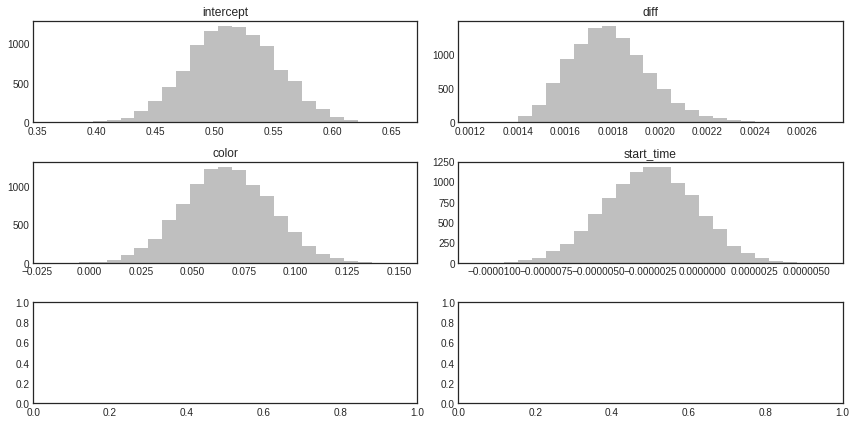

In [83]:
fig, axs = plot_bootstrap_coefs(balanced_bootstrap, balanced_features.columns, n_col=2)
fig.tight_layout()

In [84]:
y_hat = balanced_model.predict(balanced_features.values)

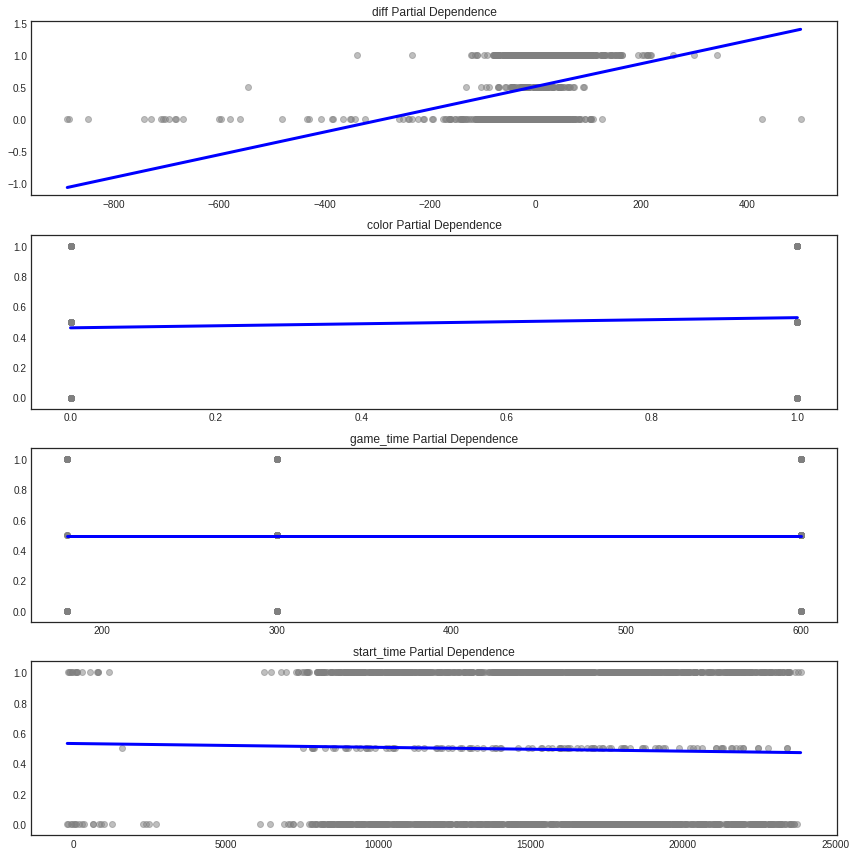

In [85]:
fig, axs = plot_partial_dependences(
    balanced_model, X=X, var_names=['diff', 'color', 'game_time', 'start_time'],
    pipeline=balanced_pipeline, y=y)
fig.tight_layout()

In [86]:
def rss(y, y_hat):
    return np.sum((y - y_hat)**2)

In [87]:
print("RSS: {}".format(rss(y, y_hat)))

RSS: 372.2190850301031


In [88]:
def rsq(y, y_hat):
    ss_tot = rss(y, np.mean(y))
    ss_res = rss(y, y_hat)
    return 1 - (ss_res / ss_tot)

In [89]:
print("R^2: {}".format(rsq(y, y_hat)))

R^2: 0.1255558097498638


In [90]:
def bootstrap_rsq(X, y, pipeline, n_boot=10000):
    rsqs = []
    for _ in range(n_boot):
        X_boot, y_boot = resample(X, y)
        X_transform = pipeline.transform(X_boot)
        model = LinearRegression(fit_intercept=False)
        model.fit(X_transform.values, y_boot)
        y_boot_hat = model.predict(X_transform.values)
        rsqs.append(rsq(y_boot, y_boot_hat))
    return rsqs

In [91]:
rsqs = bootstrap_rsq(X, y, balanced_pipeline)

Text(0.5,0,'$R^2$')

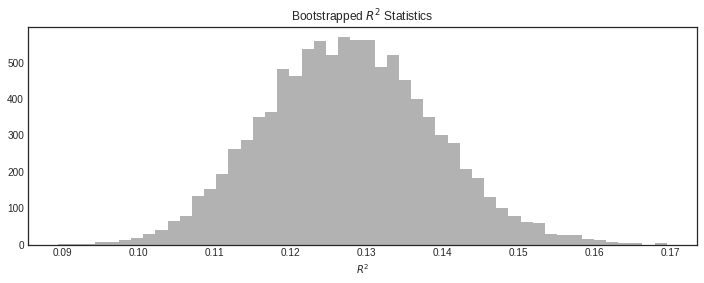

In [92]:
fig, ax = plt.subplots(figsize=(12, 4))
_ = ax.hist(rsqs, bins=50, color="grey", alpha=0.6)
ax.set_title("Bootstrapped $R^2$ Statistics")
ax.set_xlabel("$R^2$")

In [ ]:
def plot_many_residuals(var_names, y_hat, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = cdf[name]
        residual_plot(ax, x, y, y_hat)
        ax.set_xlabel(name)
        ax.set_title("Model Residuals by {}".format(name))
    return fig, axs

In [ ]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")

In [ ]:
# weekday_fit = Pipeline([('weekday', ColumnSelector(name='weekday')), (
#     'weekday_spline', LinearSpline(knots=[0, 1, 2, 3, 4, 5, 6]))])
# game_time_fit = Pipeline([('game_time', ColumnSelector(name='game_time')), (
#     'game_time_spline', LinearSpline(knots=[150, 300, 450, 600]))])
# color_fit = Pipeline([('color', ColumnSelector(name='color')), (
#     'color_spline', LinearSpline(knots=[0, 1]))])
# elo_fit = Pipeline([('elo', ColumnSelector(name='elo')), (
#     'elo_spline', LinearSpline(knots=[600, 700, 800, 900, 1000]))])
# diff_fit = Pipeline([('diff', ColumnSelector(name='diff')), (
#     'diff_spline', LinearSpline(knots=[-500, -100, -50, -20, -10, -5, 0, 0, 5, 10, 20, 50, 100, 500]))])
# opp_elo_fit = Pipeline([('opp_elo', ColumnSelector(name='opp_elo')), (
#     'opp_elo_spline', LinearSpline(knots=[600, 700, 800, 900, 1000, 1100, 1300, 1800]))])
# day_fit = Pipeline([('day', ColumnSelector(name='day')), (
#     'day_spline', LinearSpline(knots=[5, 10, 15, 20, 25, 30]))])
# start_time_fit = Pipeline([('start_time', ColumnSelector(name='start_time')), (
#     'start_time_spline', LinearSpline(knots=[0, 8000, 12000, 16000, 18000, 20000, 23999]))])

# weekday_fit.transform(cdf)
# game_time_fit.transform(cdf)
# color_fit.transform(cdf)
# elo_fit.transform(cdf)
# diff_fit.transform(cdf)
# opp_elo_fit.transform(cdf)
# day_fit.transform(cdf)
# start_time_fit.transform(cdf)
# print('hello')

In [ ]:
# def plot_basis(axs, basis_expansion, t):
#     basis = basis_expansion.fit_transform(t)
#     for idx, ax in enumerate(axs.flatten()):
#         ax.plot(t, basis[:, idx])

In [ ]:
# def plot_one_univariate(ax, var_name, mask=None, bootstrap=100):
#     if mask is None:
#         plot_univariate_smooth(ax, cdf[var_name].values.reshape(-1, 1),
#                                cdf['result'], bootstrap=bootstrap)
#     else:
#         plot_univariate_smooth(ax, cdf[var_name].values.reshape(-1, 1),
#                                cdf['result'], mask=mask, bootstrap=bootstrap)

In [ ]:
# def plot_many_predicteds_vs_actuals(var_names, y_hat, n_bins=50):
#     fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
#     for ax, name in zip(axs, var_names):
#         x = cdf[name]
#         predicteds_vs_actuals(ax, x, cdf["result"], y_hat, n_bins=n_bins)
#         ax.set_title("{} Predicteds vs. Actuals".format(name))
#     return fig, axs

In [ ]:
# var_names = ['elo', 'opp_elo', 'diff',
#              'color', 'game_time', 'start_time', 'weekday', 'day']
# y_hat = model.predict(features.values)

In [ ]:
# def residual_plot(ax, x, y, y_hat, n_bins=50):
#     residuals = y - y_hat
#     ax.axhline(0, color="black", linestyle="--")
#     ax.scatter(x, residuals, color="grey", alpha=0.5)
#     ax.set_ylabel("Residuals ($y - \hat y$)")
# fig, ax = plt.subplots(figsize=(12, 3))
# residual_plot(ax, y_hat, cdf["result"], y_hat)
# ax.set_title("Residuals by Predicted Values")
# ax.set_xlabel("$\hat y$")
# plt.show()